In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

# Load the training data into feature matrix, class labels, and event ids:

In [2]:
from helpers import *
DATA_TRAIN_PATH = '../Dataset/train.csv'
y, X, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
import cross_validation as cross_val
from pretreatement import *
from plots import plot_densities_all_features, plot_correlation_feature_label

# Preparation and Treatement of Dataset with different techniques

### $\bullet$ No pretreatement

In [4]:
dataset = {"no_pretreatement": {"tX": add_bias_column(X), "y": y}}

### $\bullet$ Discard samples with missing measures

In [5]:
def remove_missing_measures(X, y):
    """Remove missing measures and outliers of the dataset. This function 
       also standardize the input X and add the bias column.  
    
    Args:
        X::[np.array]
            The input measures.
        y::[np.array]
            The output measures associated to the input measures X.
    Returns:
        dataset::[dict]
            A dictionnary containing the pre-treated input and output as well 
            as the mean and the standard deviation of the pre-treated input.
    """
    print(f"Number of initial samples: {X.shape[0]}")

    X_new, y_new = drop_uncomplete_measures(X, y)
    print(f"Number of samples without missed measure: {X_new.shape[0]}")

    X_new, y_new = remove_outliers(X_new, y_new)
    print(f"Number of samples without missed measure nor outliers: {X_new.shape[0]}")

    X_new, mean_x, std_x = standardize(X_new)
    tX = add_bias_column(X_new)
    
    return {"tX": tX, "y": y_new, "mean_x": mean_x, "std_x": std_x}
    

dataset["no_missing_measures"] = remove_missing_measures(X, y)

Number of initial samples: 250000
Number of samples without missed measure: 68114
Number of samples without missed measure nor outliers: 58610


### $\bullet$ Discard samples with missing measures and filtering features by correlation with labels

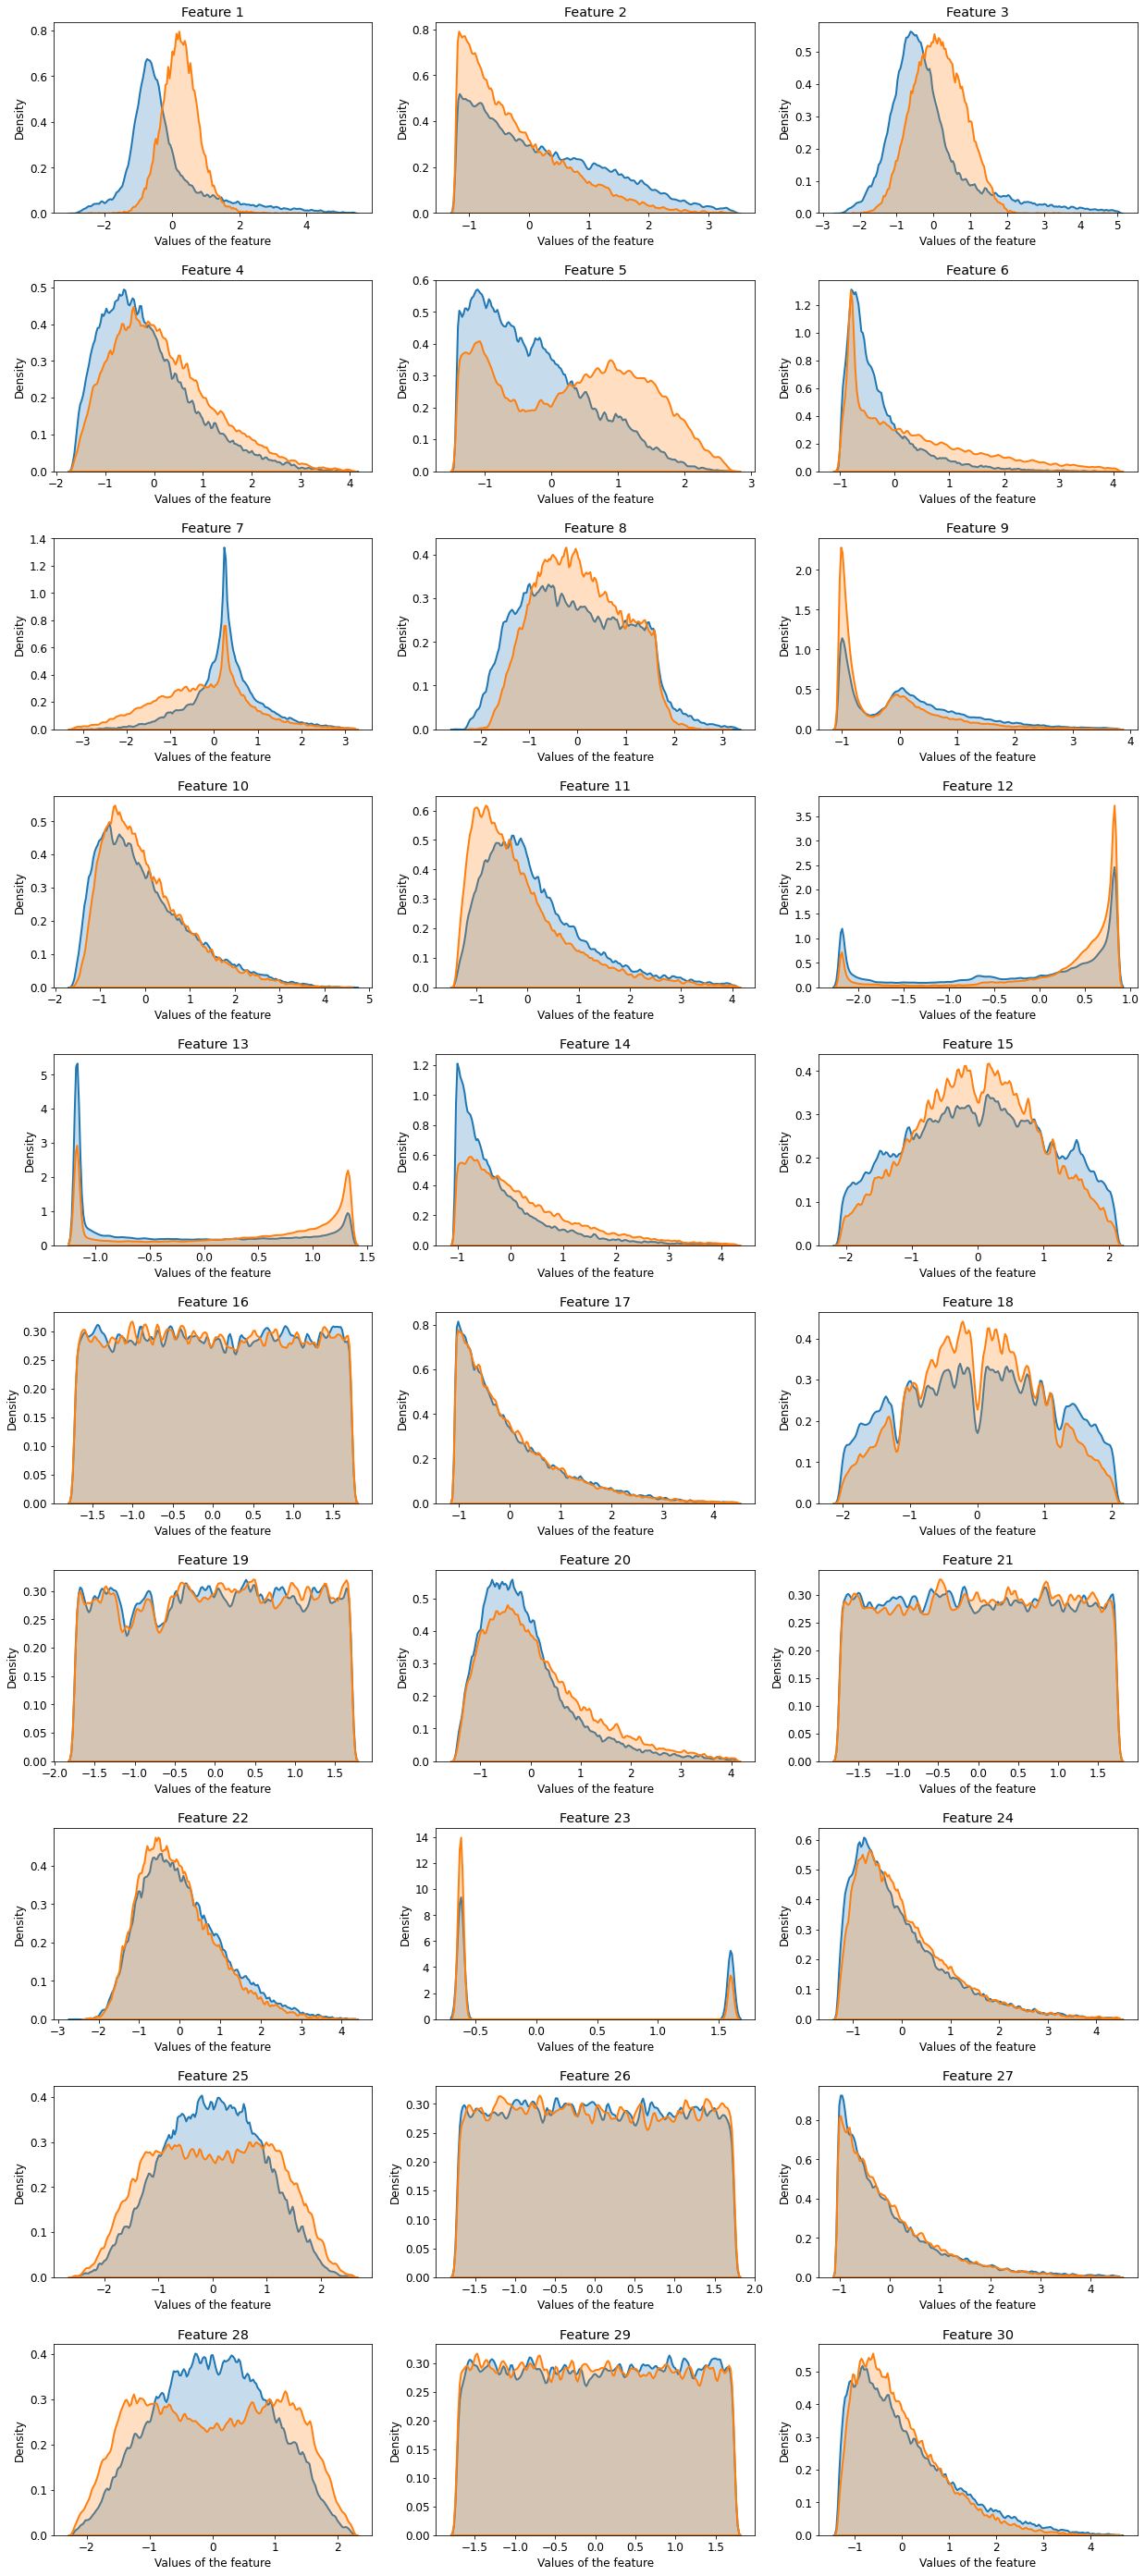

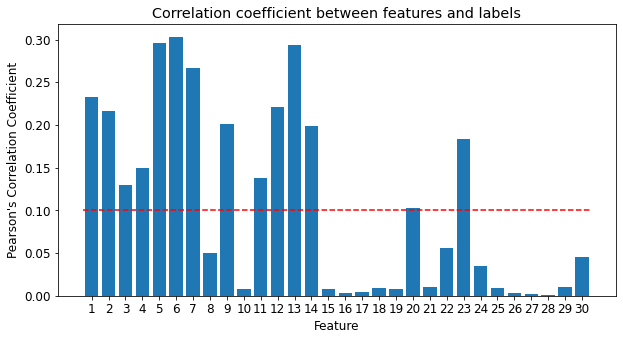

Number Initial Features: 30
Number Kept Features: 14
Number Kept DER Features: 11
Number Kept PRI Features: 3


In [6]:
def correlation_feature_labels(X, y):
    """Compute the correlation coefficient of each feature with the labels.  
    
    Args:
        X::[np.array]
            The input measures.
        y::[np.array]
            The output measures associated to the input measures X.
    Returns:
        corr_coeffs::[list]
            A list containing the correlation coefficient of each feature with 
            the labels.
    """
    n_features = X.shape[1]
    corr_coeffs = np.zeros(n_features)
    for feature in range(n_features):
        corr_coeffs[feature] = np.corrcoef(X[:, feature], y)[0,1]
        
    return corr_coeffs


def feature_correlation_filtering(X, y, thr):
    """Remove missing measures and outliers of the dataset. This function 
       also standardize the input X. It then remove the features that have 
       a correlation coefficient above a threshold. Finally it adds a bias 
       column to the input.  
    
    Args:
        X::[np.array]
            The input measures.
        y::[np.array]
            The output measures associated to the input measures X.
        thr::[float]
            Threshold value of correlation coefficient from which we will decide 
            to keep or not the feature.
    Returns:
        dataset::[dict]
            A dictionnary containing the pre-treated input and output as well 
            as the mean and the standard deviation of the pre-treated input, and
            finally a list that indicate if which feature has been kept (where True 
            holds for kept and false for not kept).
    """
    X_new, y_new = drop_uncomplete_measures(X, y)
    X_new, y_new = remove_outliers(X_new, y_new)
    X_new, mean_x, std_x = standardize(X_new)

    plot_densities_all_features(X_new, y_new)
    
    corr_coeffs = correlation_feature_labels(X_new, y_new)
    
    plot_correlation_feature_label(corr_coeffs, thr)

    kept_features = np.abs(corr_coeffs) > thr
    X_new = X_new[:, kept_features]

    tX = add_bias_column(X_new)

    print(f"Number Initial Features: {X.shape[1]}")
    print(f"Number Kept Features: {sum(kept_features)}")
    print(f"Number Kept DER Features: {sum(kept_features[:13])}")
    print(f"Number Kept PRI Features: {sum(kept_features[13:])}")
    
    return {"tX": tX, "y": y_new, "mean_x": mean_x, "std_x": std_x, "kept_features": kept_features}
    

dataset["corr_filtered_features"] = feature_correlation_filtering(X, y, thr=0.1)

### $\bullet$ Imputing missing measures with feature's mean

In [7]:
def impute_missing_measures(X, y):
    """Impute missing measures of the input with the mean of the corresponding 
       feature. It removes also the outliers of the dataset, standardizes the input 
       X and finally adds the bias column.  
    
    Args:
        X::[np.array]
            The input measures.
        y::[np.array]
            The output measures associated to the input measures X.
    Returns:
        dataset::[dict]
            A dictionnary containing the pre-treated input and output as well 
            as the mean and the standard deviation of the pre-treated input. It also 
            contains a list of the mean by which the missing measures have been imputed.
    """
    X_new, imputed_mean_x = impute_with_mean(X)

    X_new, y_new = remove_outliers(X_new, y)
    print(f"Number of samples without outliers: {X_new.shape}")

    X_new, mean_x, std_x = standardize(X_new)
    tX = add_bias_column(X_new)
    
    return {"tX": tX, "y": y_new, "imputed_mean_x": imputed_mean_x, "mean_x": mean_x, "std_x": std_x}
    

dataset["impute_missing_measures"] = impute_missing_measures(X, y)

Number of samples without outliers: (210385, 30)


### $\bullet$ Augmented features with polynomial basis

In [8]:
def feature_augmentation(X, y, degrees):
    """Impute missing measures of the input with the mean of the corresponding 
       feature and remove outliers of the dataset. The function then augments the 
       features with a polynomial basis, standardizes the augmented input X and 
       add the bias column.  
    
    Args:
        X::[np.array]
            The input measures.
        y::[np.array]
            The output measures associated to the input measures X.
        degrees::[list]
            List of the degrees with which we want to augment our features.
    Returns:
        dataset_degrees::[dict]
            A dictionnary where the keys is the degree used and the value is a dictionnary 
            containing the pre-treated input corresponding to the feature augmentation with
            the polynomial basis of the degree in the key and the output as well as the mean 
            and the standard deviation of the pre-treated input.
    """
    X_new, imputed_mean_x = impute_with_mean(X)
    X_new, y_new = remove_outliers(X_new, y)
    
    dataset_degrees = {}
    
    for degree in degrees:
        X_poly = build_poly(X_new, degree)
        X_poly, mean_x, std_x = standardize(X_poly)
        tX = add_bias_column(X_poly)
        dataset_degrees[degree] = {"tX": tX, "y": y_new, "imputed_mean_x": imputed_mean_x, "mean_x": mean_x, "std_x": std_x}
    
    return dataset_degrees
        
dataset["feature_augmentation"] = feature_augmentation(X, y, (2,3,5))

# Testbench

In [9]:
def summary(results):
    """Print the results of the cross-validation for each method.
    
    Args:
        results::[dict]
            Dictionnary where the keys corresponds to the name of a method and the values 
            are the results of the cross-validation for the method in key.
    """
    for method in results.keys():
        print(f"Results from cross-validation of {method.upper()}:")
        for key, value in results[method].items():
            if key != "w":
                print(f"    {key:<15}: {value:.5g}")
        print()
    
results = {}

### $\bullet$ Training with no pretreatement

In [10]:
def train_all_no_pretreatement(y, tX):
    """Perform the cross-validation for each method. For each method, we store a dictionary 
       that contains the best hyperparameter value found during the cross-validation, its 
       associated training accuracy, its associated validation accuracy and its associated 
       weight.
    
     Args:
        y::[np.array]
            The output measures associated to the input measures tX.
        tX::[np.array]
            The input measures.
    Returns:
        results::[dict]
            Dictionnary where the keys corresponds to the name of a method and the values 
            are the results of the cross-validation for the method in key.
    """
    results = {}
    
    results["least_squares_GD"]        = cross_val.least_squares_GD(y, tX, gamma_range=(1e-9, 1e-5), max_iters=10000)
    
    results["least_squares_SGD"]       = cross_val.least_squares_SGD(y, tX, gamma_range=(1e-9, 1e-5), max_iters=20000)
    
    results["least_squares"]           = cross_val.least_squares(y, tX)
    
    results["ridge_regression"]        = cross_val.ridge_regression(y, tX, lambda_range=(1e-5, 1e-1))
    
    results["logistic_regression"]     = cross_val.logistic_regression(y, tX, gamma_range=(1e-9, 1e-5), max_iters=10000)
    
    results["reg_logistic_regression"] = cross_val.reg_logistic_regression(y, tX, gamma_range=(1e-9, 1e-5), lambda_range=(1e-5, 1e-1), max_iters=10000)
    
#    results["knn"]                     = cross_val.knn(y, tX, k_range=(5, 11))
    
    results["svm"] = cross_val.svm(y, tX, gamma_range=(1e-13, 1e-9), lambda_range=(1e-5, 1e-1), max_iters=10000)
    
    summary(results)
    return results    


results["no_pretreatement"] = train_all_no_pretreatement(dataset["no_pretreatement"]["y"], dataset["no_pretreatement"]["tX"])

Results from cross-validation of LEAST_SQUARES_GD:
    train_accuracy : 0.69754
    val_accuracy   : 0.69751
    gamma          : 3.1623e-06

Results from cross-validation of LEAST_SQUARES_SGD:
    train_accuracy : 0.67158
    val_accuracy   : 0.68286
    gamma          : 1e-06

Results from cross-validation of LEAST_SQUARES:
    train_accuracy : 0.74497
    val_accuracy   : 0.74484

Results from cross-validation of RIDGE_REGRESSION:
    train_accuracy : 0.74493
    val_accuracy   : 0.74476
    lambda         : 0.0001

Results from cross-validation of LOGISTIC_REGRESSION:
    train_accuracy : 0.69498
    val_accuracy   : 0.69317
    gamma          : 1e-05

Results from cross-validation of REG_LOGISTIC_REGRESSION:
    train_accuracy : 0.69278
    val_accuracy   : 0.69456
    gamma          : 1e-05
    lambda         : 0.0031623

Results from cross-validation of SVM:
    train_accuracy : 0.6974
    val_accuracy   : 0.696
    gamma          : 1e-10
    lambda         : 0.0031623



### $\bullet$ Training discarding samples with missing measures

In [11]:
def train_all_no_missing_measures(y, tX):
    """Perform the cross-validation for each method. For each method, we store a dictionary 
       that contains the best hyperparameter value found during the cross-validation, its 
       associated training accuracy, its associated validation accuracy and its associated 
       weight.
    
     Args:
        y::[np.array]
            The pre-treated output measures associated to the pre-treated input measures tX.
        tX::[np.array]
            The pre-treated input measures.
    Returns:
        results::[dict]
            Dictionnary where the keys corresponds to the name of a method and the values 
            are the results of the cross-validation for the method in key.
    """
    results = {}
    
    results["least_squares_GD"]        = cross_val.least_squares_GD(y, tX, gamma_range=(1e-3, 1e+1), max_iters=10000)
    
    results["least_squares_SGD"]       = cross_val.least_squares_SGD(y, tX, gamma_range=(1e-5, 1e-1), max_iters=15000)
    
    results["least_squares"]           = cross_val.least_squares(y, tX)
    
    results["ridge_regression"]        = cross_val.ridge_regression(y, tX, lambda_range=(1e-5, 1e-1))
    
    results["logistic_regression"]     = cross_val.logistic_regression(y, tX, gamma_range=(1e-7, 1e-3), max_iters=50000)
    
    results["reg_logistic_regression"] = cross_val.reg_logistic_regression(y, tX, gamma_range=(1e-7, 1e-3), lambda_range=(1e-5, 1e-1), max_iters=50000)
    
#    results["knn"]                     = cross_val.knn(y, tX, k_range=(5, 11))
    
    results["svm"] = cross_val.svm(y, tX, gamma_range=(1e-7, 1e-3), lambda_range=(1e-3, 1e+1), max_iters=10000)
    
    summary(results)
    return results


results["no_missing_measures"] = train_all_no_missing_measures(dataset["no_missing_measures"]["y"], dataset["no_missing_measures"]["tX"])

Results from cross-validation of LEAST_SQUARES_GD:
    train_accuracy : 0.73399
    val_accuracy   : 0.73307
    gamma          : 3.1623

Results from cross-validation of LEAST_SQUARES_SGD:
    train_accuracy : 0.72592
    val_accuracy   : 0.72477
    gamma          : 0.1

Results from cross-validation of LEAST_SQUARES:
    train_accuracy : 0.73385
    val_accuracy   : 0.73371

Results from cross-validation of RIDGE_REGRESSION:
    train_accuracy : 0.73385
    val_accuracy   : 0.73313
    lambda         : 0.00031623

Results from cross-validation of LOGISTIC_REGRESSION:
    train_accuracy : 0.69741
    val_accuracy   : 0.70017
    gamma          : 0.001

Results from cross-validation of REG_LOGISTIC_REGRESSION:
    train_accuracy : 0.70073
    val_accuracy   : 0.69819
    gamma          : 0.001
    lambda         : 3.1623e-05

Results from cross-validation of SVM:
    train_accuracy : 0.71856
    val_accuracy   : 0.72974
    gamma          : 3.1623e-05
    lambda         : 0.31623



### $\bullet$ Training discarding samples with missing measures and filtering features by correlation with labels

In [12]:
def train_all_corr_filtered_features(y, tX):
    """Perform the cross-validation for each method. For each method, we store a dictionary 
       that contains the best hyperparameter value found during the cross-validation, its 
       associated training accuracy, its associated validation accuracy and its associated 
       weight.
    
     Args:
        y::[np.array]
            The pre-treated output measures associated to the pre-treated input measures tX.
        tX::[np.array]
            The pre-treated input measures.
    Returns:
        results::[dict]
            Dictionnary where the keys corresponds to the name of a method and the values 
            are the results of the cross-validation for the method in key.
    """
    results = {}
    
    results["least_squares_GD"]        = cross_val.least_squares_GD(y, tX, gamma_range=(1e-3, 1e+1), max_iters=10000)
    
    results["least_squares_SGD"]       = cross_val.least_squares_SGD(y, tX, gamma_range=(1e-5, 1e-1), max_iters=15000)
    
    results["least_squares"]           = cross_val.least_squares(y, tX)
    
    results["ridge_regression"]        = cross_val.ridge_regression(y, tX, lambda_range=(1e-5, 1e-1))
    
    results["logistic_regression"]     = cross_val.logistic_regression(y, tX, gamma_range=(1e-7, 1e-3), max_iters=50000)
    
    results["reg_logistic_regression"] = cross_val.reg_logistic_regression(y, tX, gamma_range=(1e-7, 1e-3), lambda_range=(1e-5, 1e-1), max_iters=50000)
    
#    results["knn"]                     = cross_val.knn(y, tX, k_range=(5, 11))
    
    results["svm"] = cross_val.svm(y, tX, gamma_range=(1e-7, 1e-3), lambda_range=(1e-3, 1e+1), max_iters=10000)
    
    summary(results)
    return results


results["corr_filtered_features"] = train_all_corr_filtered_features(dataset["corr_filtered_features"]["y"], dataset["corr_filtered_features"]["tX"])

Results from cross-validation of LEAST_SQUARES_GD:
    train_accuracy : 0.72121
    val_accuracy   : 0.72097
    gamma          : 3.1623

Results from cross-validation of LEAST_SQUARES_SGD:
    train_accuracy : 0.71703
    val_accuracy   : 0.71733
    gamma          : 0.1

Results from cross-validation of LEAST_SQUARES:
    train_accuracy : 0.72121
    val_accuracy   : 0.72145

Results from cross-validation of RIDGE_REGRESSION:
    train_accuracy : 0.72117
    val_accuracy   : 0.72112
    lambda         : 0.00031623

Results from cross-validation of LOGISTIC_REGRESSION:
    train_accuracy : 0.69877
    val_accuracy   : 0.70044
    gamma          : 0.001

Results from cross-validation of REG_LOGISTIC_REGRESSION:
    train_accuracy : 0.70537
    val_accuracy   : 0.69797
    gamma          : 0.001
    lambda         : 0.031623

Results from cross-validation of SVM:
    train_accuracy : 0.7225
    val_accuracy   : 0.7231
    gamma          : 3.1623e-05
    lambda         : 0.0031623



### $\bullet$ Training imputing missing measures with feature's mean

In [13]:
def train_all_impute_missing_measures(y, tX):
    """Perform the cross-validation for each method. For each method, we store a dictionary 
       that contains the best hyperparameter value found during the cross-validation, its 
       associated training accuracy, its associated validation accuracy and its associated 
       weight.
    
     Args:
        y::[np.array]
            The pre-treated output measures associated to the pre-treated input measures tX.
        tX::[np.array]
            The pre-treated input measures.
    Returns:
        results::[dict]
            Dictionnary where the keys corresponds to the name of a method and the values 
            are the results of the cross-validation for the method in key.
    """
    results = {}
    
    results["least_squares_GD"]        = cross_val.least_squares_GD(y, tX, gamma_range=(1e-3, 1e+1), max_iters=10000)
    
    results["least_squares_SGD"]       = cross_val.least_squares_SGD(y, tX, gamma_range=(1e-5, 1e-1), max_iters=15000)
    
    results["least_squares"]           = cross_val.least_squares(y, tX)
    
    results["ridge_regression"]        = cross_val.ridge_regression(y, tX, lambda_range=(1e-5, 1e-1))
    
    results["logistic_regression"]     = cross_val.logistic_regression(y, tX, gamma_range=(1e-7, 1e-3), max_iters=50000)
    
    results["reg_logistic_regression"] = cross_val.reg_logistic_regression(y, tX, gamma_range=(1e-7, 1e-3), lambda_range=(1e-5, 1e-1), max_iters=50000)
    
#    results["knn"]                     = cross_val.knn(y, tX, k_range=(5, 11))
    
    results["svm"] = cross_val.svm(y, tX, gamma_range=(1e-7, 1e-3), lambda_range=(1e-3, 1e+1), max_iters=10000)
    
    summary(results)
    return results


results["impute_missing_measures"] = train_all_impute_missing_measures(dataset["impute_missing_measures"]["y"], dataset["impute_missing_measures"]["tX"])

Results from cross-validation of LEAST_SQUARES_GD:
    train_accuracy : 0.76239
    val_accuracy   : 0.76212
    gamma          : 3.1623

Results from cross-validation of LEAST_SQUARES_SGD:
    train_accuracy : 0.75313
    val_accuracy   : 0.75363
    gamma          : 0.1

Results from cross-validation of LEAST_SQUARES:
    train_accuracy : 0.76243
    val_accuracy   : 0.76216

Results from cross-validation of RIDGE_REGRESSION:
    train_accuracy : 0.76239
    val_accuracy   : 0.76217
    lambda         : 0.0001

Results from cross-validation of LOGISTIC_REGRESSION:
    train_accuracy : 0.72094
    val_accuracy   : 0.71039
    gamma          : 0.001

Results from cross-validation of REG_LOGISTIC_REGRESSION:
    train_accuracy : 0.71961
    val_accuracy   : 0.71161
    gamma          : 0.001
    lambda         : 3.1623e-05

Results from cross-validation of SVM:
    train_accuracy : 0.74951
    val_accuracy   : 0.75659
    gamma          : 3.1623e-06
    lambda         : 0.31623



### $\bullet$ Training imputing samples with missing measures and performing feature augmentation

In [14]:
def train_all_feature_augmentation(dataset_degrees):
    """Perform the cross-validation for each method. For each method, we store a dictionary 
       that contains the best hyperparameter value found during the cross-validation, its 
       associated training accuracy, its associated validation accuracy and its associated 
       weight.
    
     Args:
        dataset_degrees::[dict]
            A dictionnary where the keys is the degree used and the value is a dictionnary 
            containing the pre-treated input corresponding to the feature augmentation with
            the polynomial basis of the degree in the key and the output as well as the mean 
            and the standard deviation of the pre-treated input.
            
    Returns:
        results_degrees::[dict]
            A dictionnary where the keys is the degree used and the value is a dictionnary 
            where the keys corresponds to the name of a method and the values are the results 
            of the cross-validation for the method in key.
    """
    results_degrees = {}
    
    for degree, dataset in dataset_degrees.items():
        y, tX = dataset["y"], dataset["tX"]
        
        results = {}

        results["least_squares_GD"]        = cross_val.least_squares_GD(y, tX, gamma_range=(1e-3, 1e+1), max_iters=10000)

        results["least_squares_SGD"]       = cross_val.least_squares_SGD(y, tX, gamma_range=(1e-5, 1e-1), max_iters=15000)

        results["least_squares"]           = cross_val.least_squares(y, tX)

        results["ridge_regression"]        = cross_val.ridge_regression(y, tX, lambda_range=(1e-5, 1e-1))

        results["logistic_regression"]     = cross_val.logistic_regression(y, tX, gamma_range=(1e-7, 1e-3), max_iters=50000)

        results["reg_logistic_regression"] = cross_val.reg_logistic_regression(y, tX, gamma_range=(1e-7, 1e-3), lambda_range=(1e-5, 1e-1), max_iters=50000)

#        results["knn"]                     = cross_val.knn(y, tX, k_range=(5, 11))

        results["svm"] = cross_val.svm(y, tX, gamma_range=(1e-7, 1e-3), lambda_range=(1e-3, 1e+1), max_iters=10000)
        
        
        print(f"DEGREE: {degree}")
        summary(results)
        print()
        results_degrees[degree] = results

    return results_degrees

results["feature_augmentation"] = train_all_feature_augmentation(dataset["feature_augmentation"])


DEGREE: 2
Results from cross-validation of LEAST_SQUARES_GD:
    train_accuracy : 0.79252
    val_accuracy   : 0.79216
    gamma          : 1

Results from cross-validation of LEAST_SQUARES_SGD:
    train_accuracy : 0.76171
    val_accuracy   : 0.76712
    gamma          : 0.1

Results from cross-validation of LEAST_SQUARES:
    train_accuracy : 0.79395
    val_accuracy   : 0.79369

Results from cross-validation of RIDGE_REGRESSION:
    train_accuracy : 0.79393
    val_accuracy   : 0.79368
    lambda         : 1e-05

Results from cross-validation of LOGISTIC_REGRESSION:
    train_accuracy : 0.71335
    val_accuracy   : 0.72126
    gamma          : 0.001

Results from cross-validation of REG_LOGISTIC_REGRESSION:
    train_accuracy : 0.70891
    val_accuracy   : 0.71319
    gamma          : 0.001
    lambda         : 3.1623e-05

Results from cross-validation of SVM:
    train_accuracy : 0.77987
    val_accuracy   : 0.77296
    gamma          : 3.1623e-06
    lambda         : 0.0031623




## Generate predictions and save ouput in csv format for submission:

In [15]:
DATA_TEST_PATH = '../Dataset/test.csv'
_, X_test, ids_test = load_csv_data(DATA_TEST_PATH)

Applying pretreatement to dataset (imputing missing measures and performing feature augmentation with polynomial basis of degree 5)

In [16]:
degree = 5

def pretreat_test_set(X, degree, imputed_mean_x, mean_x, std_x):
    """Impute missing measures of the input of the test set with the mean of the corresponding 
       feature from the training set. The function then augments the features of the test set
       with a polynomial basis, standardizes the augmented input X using mean and standard 
       deviation of the training set and adds the bias column.
    
     Args:
        X::[np.array]
            The input measures of the test set.
        degree::[int]
            The degree which we want to augment our features.
        imputed_mean_x::[np.array]
            The mean of the features from the training set to impute the missing measures of the 
            test set in the same way as the training set.
        mean_x::[np.array]
            The mean of the features from the training set to make the standardization of the 
            test set in the same way as the training set.
        std_x::[np.array]
            The standard deviation of the features from the training set to make the standardization
            of the test set in the same way as the training set.
    Returns:
        tX::[np.array]
            The pre-treated input measures for test set.
    """
    X_new, _ = impute_with_mean(X, imputed_mean_x) 
    X_poly = build_poly(X_new, degree)
    X_poly, _, _ = standardize(X_poly, mean_x, std_x)
    tX = add_bias_column(X_poly)
    
    return tX

tX_test = pretreat_test_set(X_test, degree,
                            dataset["feature_augmentation"][degree]["imputed_mean_x"],
                            dataset["feature_augmentation"][degree]["mean_x"],
                            dataset["feature_augmentation"][degree]["std_x"])

Predicting labels for train set using weights with highest validation accuracy

In [17]:
OUTPUT_PATH = '../Dataset/submission.csv'
y_pred = predict_labels(results["feature_augmentation"][degree]["least_squares"]["w"], tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)